In [1]:
# import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


# setup the SCF bar

In [2]:
#Compute normalization rho_0

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6

Mbar=10**10 #Msun, half of what Wang is using, same as Pearson


def rho1(R,z):
    return (2.*np.pi*x0*y0)*R*np.exp(-0.5*(np.sqrt(R**4 + (z/z0)**4)))

rho1norm= integrate.nquad(rho1,[[0,np.inf],[-np.inf,np.inf]])[0]

def rho2(R):
    return (z0**1.85 *4.*np.pi/q**2)*R**(0.15)*np.exp(-R/z0)

rho2norm= integrate.quad(rho2,0,np.inf)[0]


rho0=Mbar/(rho1norm + rho2norm)

print (rho0)


1084351671.92


In [3]:
#define function for the bar density, using form from Dwek (1995) as of now
# transformed from cartesian to cylindrical for galpy

def r1c(R,z,p):
    return ((R**4.)*(np.cos(p)**2./x0**2 + np.sin(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return rho0*(np.exp((-r1c(R,z,p)**2.)/2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z)))



In [4]:
#compute SCF coefficients for the above defined density. 
#Following Pearson et al N=2 and L=6, a is same as r_s in Wang et al 2012
#Note: the density above is not axisymmetric


def SCFbarpotential(rho_norm=rho0,amp=1.,n=2,l=6,init_ang= 0.,pat_speed = 0.,r_order=40,cost_order=40,phi_order=40):
    omegaP=pat_speed*(ro/vo)
    
    Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        N=n+1,L=l+1,a=1./ro,radial_order=r_order,costheta_order=cost_order,phi_order=phi_order)
    
    #construct the barred potential with the coefficients computed above
    scfbar=potential.SCFPotential(amp=amp,Acos=Acos,Asin=Asin,a=0.125,normalize=False)
    #Let the bar spin!
    scfbarrot=potential.SolidBodyRotationWrapperPotential(pot=scfbar, omega=omegaP,ro=ro,vo=vo,pa=np.radians(init_ang))
    #pa = 27 deg taken from Pearson et al,.
    turn_physical_off(scfbarrot)

    return scfbarrot

(0.1, 13)

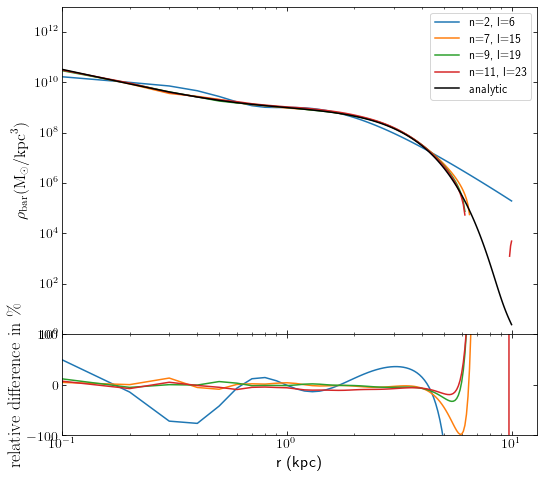

In [5]:
#plot analytic density and computed density 

rr=np.linspace(0.1,10.,100)
N=[2,7,9,11]
L=[6,15,19,23]

diff=np.zeros((len(N),len(rr)))

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(8,7)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)



for i in range(len(N)):
    scfbar=SCFbarpotential(n=N[i],l=L[i],r_order=40,cost_order=40,phi_order=40)
    dens_eval=evaluateDensities(scfbar,rr*u.kpc,0.*u.kpc,np.radians(0.),t=0.)*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.)
    diff[i]+=(rho_bar_cyl(rr,0.,0.)-dens_eval)*100/rho_bar_cyl(rr,0.,0.)
    
    loglog(rr*u.kpc,dens_eval, label=r'n={}, l={}'.format(N[i],L[i]))
loglog(rr,rho_bar_cyl(rr,0.,0.),c='k',label='analytic')
xlim(0.1,13)
plt.ylabel(r'$\rho_{\rm{bar}} (\rm{M}_{\odot}/\rm{kpc}^{3})$ ',fontsize=16)

ylim(1.,10**13.)
legend(loc='upper right')
nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)

for ii in range(len(N)):
    semilogx(rr,diff[ii])
    
plt.xlabel(r'r (kpc)',fontsize=16)
plt.ylabel(r'$\mathrm{relative\ difference\ in}\ \%$')
ylim(-100.,100)
xlim(0.1,13)

#bovy_plot.bovy_end_print("")


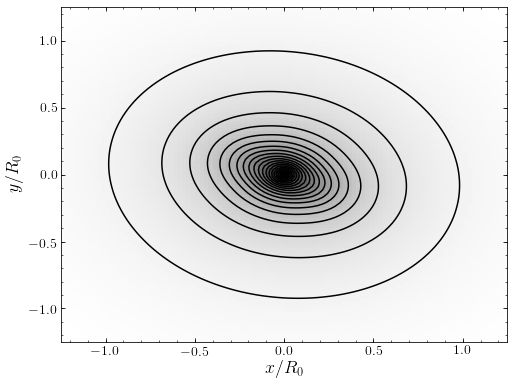

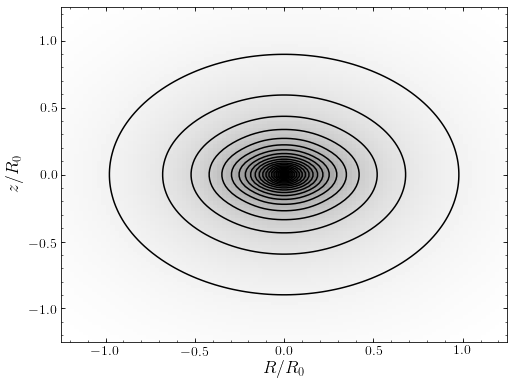

In [6]:
n=9
l=19
#plot the bar's potential contours
potential.plotPotentials(SCFbarpotential(n,l,pat_speed=35.,init_ang=180-27.),rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)
potential.plotPotentials(SCFbarpotential(n,l,pat_speed=35.,init_ang=180-27.),rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=False,phi=0.)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: invalid value encountered in divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:258: RuntimeWarning: invalid value encountered in multiply
  func = func_tilde[:,:,None]*(Acos[:,:,:]*mcos + Asin[:,:,:]*msin)*PP[None,:,:]



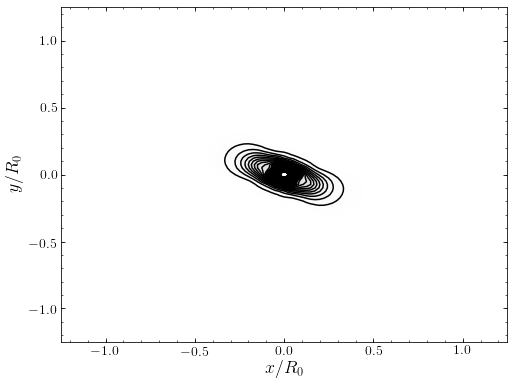

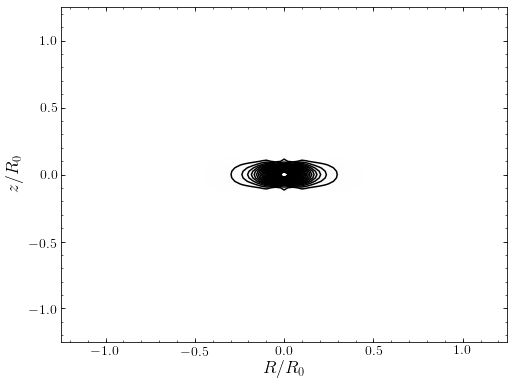

In [7]:
#plot the bar's density contours

plotDensities(SCFbarpotential(n,l,pat_speed=35.,init_ang=180-27.),rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)
plotDensities(SCFbarpotential(n,l,pat_speed=35.,init_ang=180-27.),rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80)

In [8]:
#make different bars of different strengths, pattern speed and angle
#construct the barred potential with the coefficients computed above


#pre-compute Acos and Asin to expedite computation

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        N=n+1,L=l+1,a=1./ro,radial_order=40,costheta_order=40,phi_order=40)



def MWPotentialSCFbar(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,angle=180.-27.):
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    pa=np.radians(angle)
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=pa)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    return (MWP2014SCFbar,MWP2014SCFnobar)
        
    

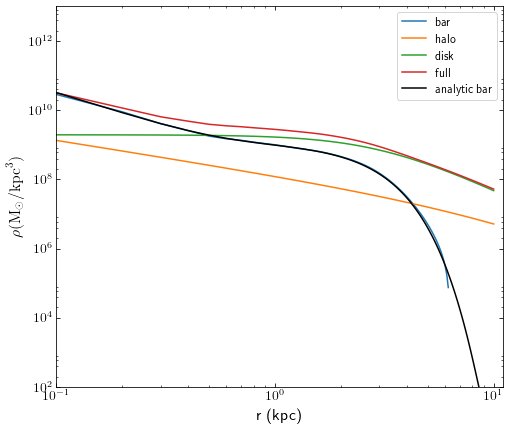

In [9]:
#plot density as a function of radius

rr=np.linspace(0.1,10.,100)

Mbar=10**10.
full_pot=MWPotentialSCFbar(Mbar,pat_speed=0.,angle=0.)[0]

disk=full_pot[0]
halo=full_pot[1]
bar=full_pot[2]

bar_dens=evaluateDensities(bar,rr*u.kpc,0.*u.kpc,np.radians(0.))*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.)
halo_dens=evaluateDensities(halo,rr*u.kpc,0.*u.kpc,np.radians(0.))*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.)
disk_dens=evaluateDensities(disk,rr*u.kpc,0.*u.kpc,np.radians(0.))*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.)
full_dens=evaluateDensities(full_pot,rr*u.kpc,0.*u.kpc,np.radians(0.))*(10**9)*bovy_conversion.dens_in_msolpc3(220.,8.)

plt.figure(figsize=(8,7))
plt.loglog(rr*u.kpc,bar_dens, label='bar')
plt.loglog(rr*u.kpc,halo_dens, label='halo')
plt.loglog(rr*u.kpc,disk_dens, label='disk')
plt.loglog(rr*u.kpc,full_dens, label='full')
plt.loglog(rr*u.kpc,rho_bar_cyl(rr,0.,0.),c='k',label='analytic bar')
plt.legend(loc='upper right')
plt.xlim(0.1,11.)
plt.ylim(100.,10**13.)
plt.ylabel(r'$\rho (\rm{M}_{\odot}/\rm{kpc}^{3})$ ',fontsize=16)
plt.xlabel(r'r (kpc)',fontsize=16)
plt.show()


/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.



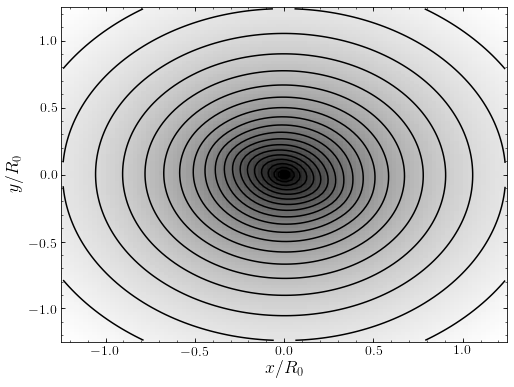

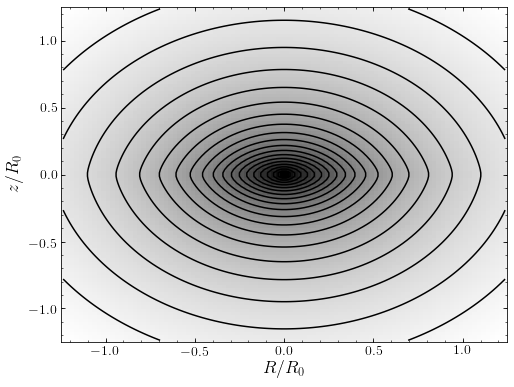

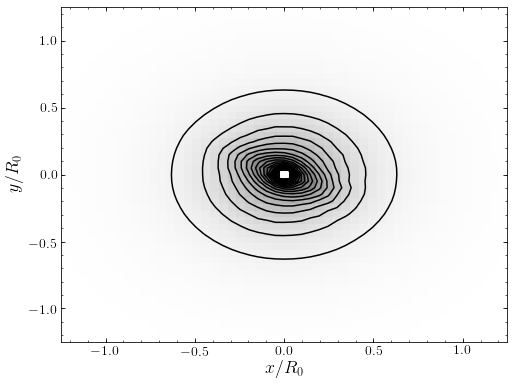

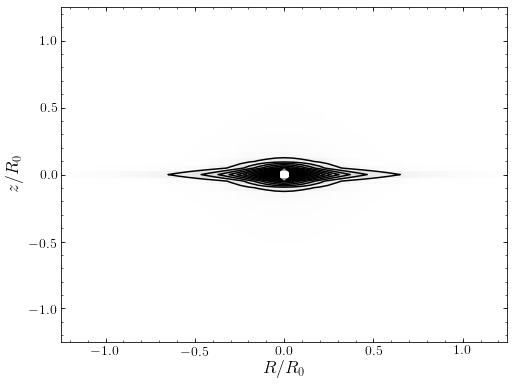

In [10]:
#plot the full MW potential contours
potential.plotPotentials(MWPotentialSCFbar(mbar=10**10.,pat_speed=35.,angle=180-27.)[0],rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)
potential.plotPotentials(MWPotentialSCFbar(mbar=10**10.,pat_speed=35.,angle=180-27.)[0],rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=False,phi=0.)

plotDensities(MWPotentialSCFbar(mbar=10**10.,pat_speed=35.,angle=180-27.)[0],rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=51,nzs=51,ncontours=20,xy=True)
plotDensities(MWPotentialSCFbar(mbar=10**10.,pat_speed=35.,angle=180-27.)[0],rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=51,nzs=51,ncontours=20)

In [11]:
#plot orbits for Mbar = 10^12 Msun, pat speed 35 km/s/kpc, angle = 27 deg
Mbar=10**10.

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,angle=180-27.)[0])
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,angle=180-27.)[1])
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,angle=180-27.)[0])
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,angle=180-27.)[1])
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()

bovy_plot.bovy_end_print('plots/orbitRz_10_10Msun_patspeed35_ang27.pdf')


In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
tight_layout()
bovy_plot.bovy_end_print('plots/orbitxy_10_10Msun_patspeed35_ang27.pdf')


In [13]:
#compute vertical force for different mass of the bar
from decimal import Decimal

from galpy.potential import evaluatezforces

mm=np.array([0.1,.25,.5,1.,2,3.])*10**10.

for ii in range(len(mm)):
    print ("%.2E Msun bar"%Decimal(mm[ii]))
    print ("No bar: {}".format(-evaluatezforces(MWPotentialSCFbar(mm[ii])[0], 1.,1.1/8.,phi=0.)*bovy_conversion.force_in_2piGmsolpc2(220.,8.)))
    print ("SCF bar: {}".format(-evaluatezforces(MWPotentialSCFbar(mm[ii])[1], 1.,1.1/8.,phi=0.)*bovy_conversion.force_in_2piGmsolpc2(220.,8.)) + "\n")

1.00E+09 Msun bar
No bar: 71.0074251027
SCF bar: 70.9886526758

2.50E+09 Msun bar
No bar: 70.2584725596
SCF bar: 70.2115414925

5.00E+09 Msun bar
No bar: 69.010218321
SCF bar: 68.9163561869

1.00E+10 Msun bar
No bar: 69.3835324839
SCF bar: 69.1958082156

2.00E+10 Msun bar
No bar: 64.3905155298
SCF bar: 64.0150669932

3.00E+10 Msun bar
No bar: 59.3974985757
SCF bar: 58.8343257709



221.938492607


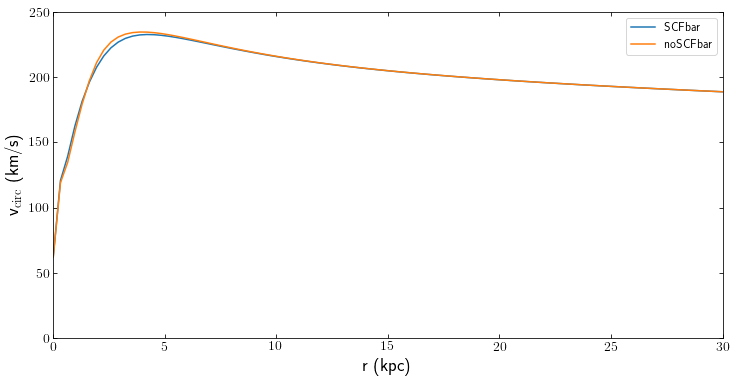

In [14]:
#Compare circular velocity between no bar and barred case for Mbar = 10**10 Msun

print (potential.vcirc(MWPotentialSCFbar(10**10)[1],1.,phi=0)*vo)

rr=np.linspace(0.001,4.,100)

plt.figure()
plt.plot(rr*8.,potential.vcirc(MWPotentialSCFbar(10**10)[1],rr,phi=0)*vo,label='SCFbar')
plt.plot(rr*8.,potential.vcirc(MWPotentialSCFbar(10**10)[0],rr,phi=0)*vo,label='noSCFbar')
plt.legend(loc='upper right')
plt.ylim(0,250)
plt.xlim(0,30)
plt.xlabel(r'r (kpc)')
plt.ylabel(r'v$_{\rm{circ}}$ (km/s)')
plt.show()

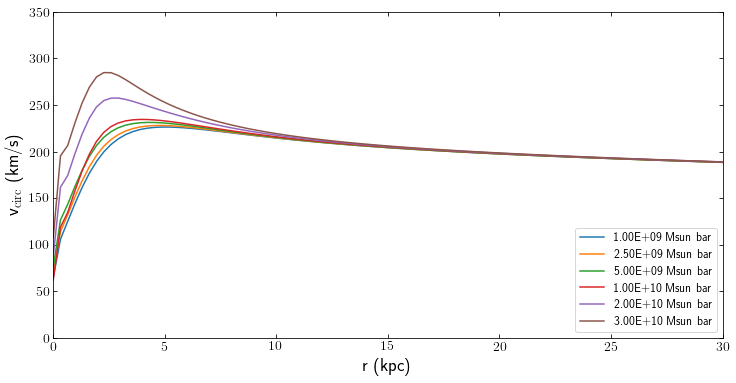

In [15]:
#plot circular velocity for different Mbar

rr=np.linspace(0.001,4.,100)

plt.figure()

for jj in range(len(mm)):
    plt.plot(rr*8.,potential.vcirc(MWPotentialSCFbar(mm[jj])[0],rr,phi=0)*vo,label="%.2E Msun bar"%Decimal(mm[jj]))
plt.legend(loc='lower right')
plt.ylim(0,350)
plt.xlim(0,30)
plt.xlabel(r'r (kpc)')
plt.ylabel(r'v$_{\rm{circ}}$ (km/s)')
plt.show()

# Compare effect of Mbar on Pal 5

In [16]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [17]:
Mbar=10**10.
pat_speed=35.
ang=180.-27.
barpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,angle=ang)[0]
nobarpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,angle=ang)[1]

In [18]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)

#Sample N points from the smooth model today 
N=1000
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)

trackRADec_leading=bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

for i in range(N):
    dtt_s[i]=numpy.digitize(dtt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[0]
    bt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[1]
    
    dtl_s[i]=numpy.digitize(dtl[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    ll_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[0]
    bl_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[1]
    
radec1t=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
radec1l=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)

[ 0.  1.  2.  3.  4.  5.]


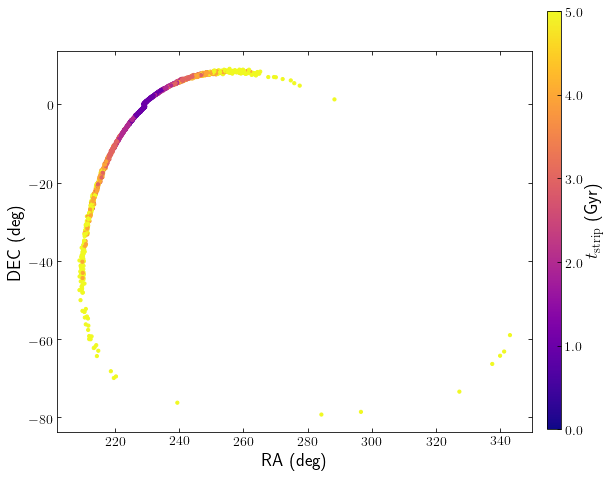

In [20]:
#plot unperturbed stream 

plt.figure(figsize=(8,7))
plt.scatter(radec1t[:,0],radec1t[:,1],s=10,color=color_from_colormap(dtt_s,cmap,0.,5.))
plt.scatter(radec1l[:,0],radec1l[:,1],s=10,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k')
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(220.,290.)
#plt.ylim(-10.,10.)
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
plt.show()


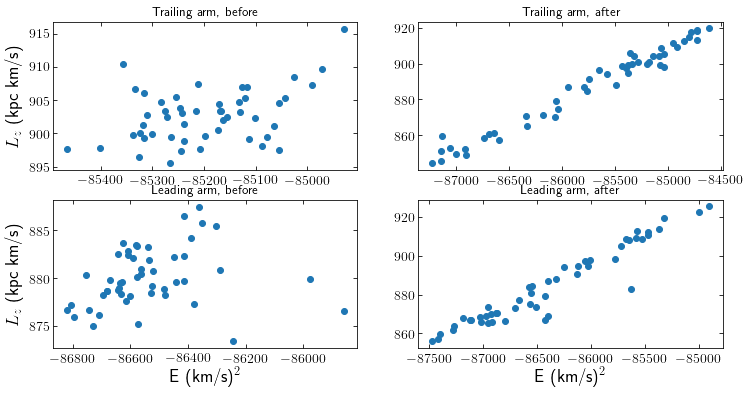

In [21]:
#plot E vs Lz

nsamp=50

Et0=[]
Et1=[]

Lzt0=[]
Lzt1=[]

El0=[]
El1=[]

Lzl0=[]
Lzl1=[]


for ii in range(nsamp):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]],ro=ro,vo=vo).flip()
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]],ro=ro,vo=vo).flip()# flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    tsl= numpy.linspace(0.,dtl[ii],1001)
    
    ot.integrate(tst,nobarpot) #integrate back to stripping point
    ott=ot(tst[-1]).flip()  #flip velocities for forward integration
    ott.integrate(tst,barpot) 
    Et0.append(ott.E(tst[0]))   #Energy at the stripping time 
    Et1.append(ott.E(tst[-1]))   # Energy at present
    Lzt0.append(ott.L(tst[0])[0,2]) #Lz at stripping time
    Lzt1.append(ott.L(tst[-1])[0,2])   #Lz at present
    
    ol.integrate(tsl,nobarpot)
    oll=ol(tsl[-1]).flip()
    oll.integrate(tsl,barpot)
    El0.append(oll.E(tsl[0]))
    El1.append(oll.E(tsl[-1]))
    Lzl0.append(oll.L(tsl[0])[0,2])
    Lzl1.append(oll.L(tsl[-1])[0,2])
    

plt.figure()
plt.subplot(2,2,1)
plt.title('Trailing arm, before')
plt.scatter(Et0,Lzt0)
plt.ylabel(r'$L_{z}$ (kpc km/s)')

plt.subplot(2,2,2)
plt.title('Trailing arm, after')
plt.scatter(Et1,Lzt1)

plt.subplot(2,2,3)
plt.title('Leading arm, before')
plt.scatter(El0,Lzl0)
plt.xlabel(r'E (km/s)$^2$')
plt.ylabel(r'$L_{z}$ (kpc km/s)')

plt.subplot(2,2,4)
plt.title('Leading arm, after')
plt.scatter(El1,Lzl1)
plt.xlabel(r'E (km/s)$^2$')

plt.savefig('E_Lz_Mbar10_10_speed35_ang27.pdf',format='pdf',dpi=1000)
plt.show()

     

# plot Jacobi integral and E vs t

51


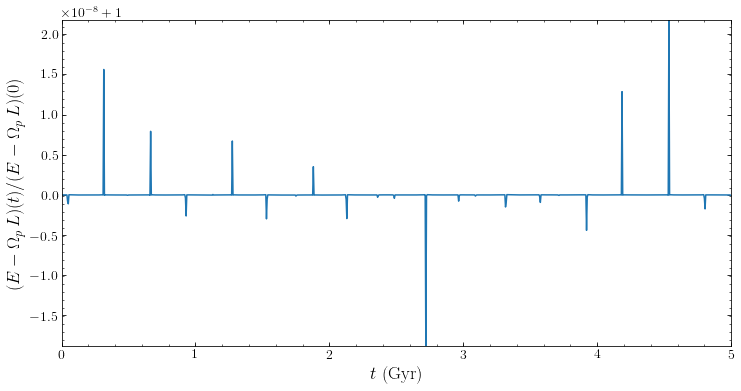

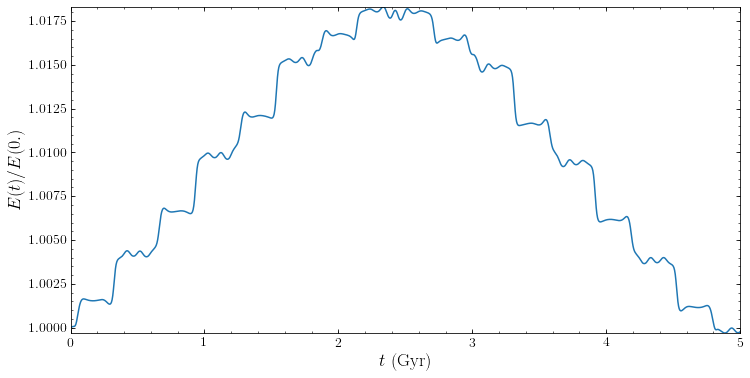

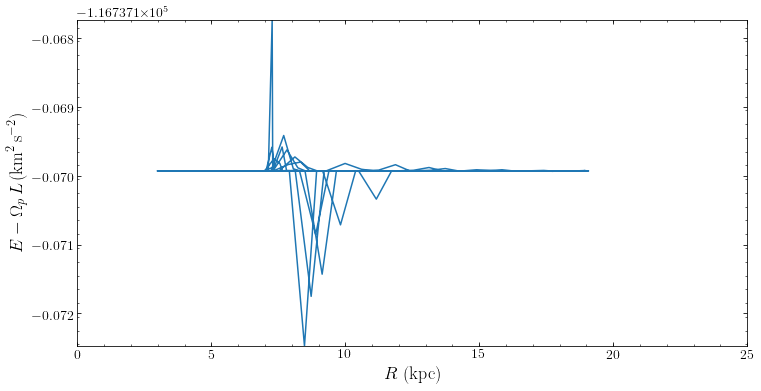

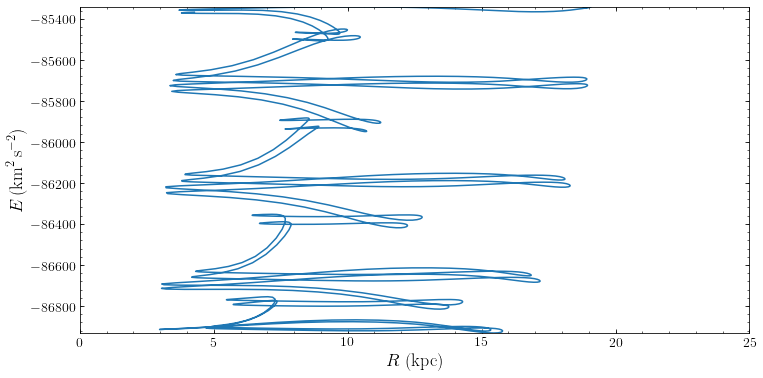

In [24]:
#randomly pick a star, integrate back in axi pot, integrate forward in barred pot

from random import randint
ind=randint(0,len(Rt)-1)
print (ind)

ts= numpy.linspace(0,5.0,1001)/bovy_conversion.time_in_Gyr(220.,8.)

#trailing arm

ot= Orbit([Rt[ind],vRt[ind],vTt[ind],zt[ind],vzt[ind],phit[ind]],ro=ro,vo=vo).flip()# flip flips the velocities for backwards integration

tst= numpy.linspace(0.,dtt[ii],1001)

    
ot.integrate(tst,nobarpot) #integrate back to stripping point
ott=ot(tst[-1]).flip()  #flip velocities for forward integration
ott.integrate(ts,barpot) 
ott.plotJacobi(normed=True)
ott.plotE(normed=True)

#plot Jacobi integral w.r.t the radius 

ott.plot(d1='R',d2='Jacobi',xrange=[0.,25])
ott.plot(d1='R',d2='E',xrange=[0.,25])

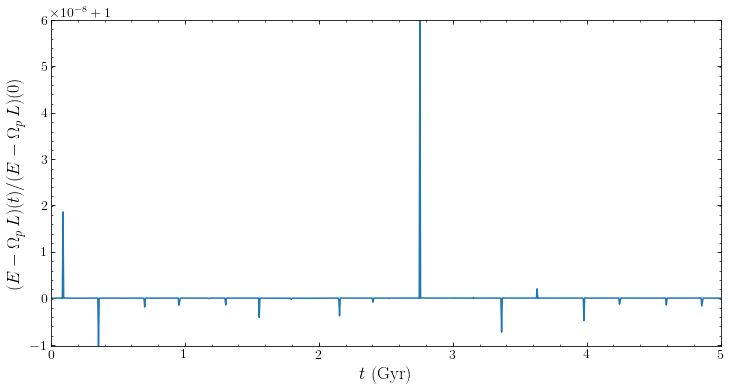

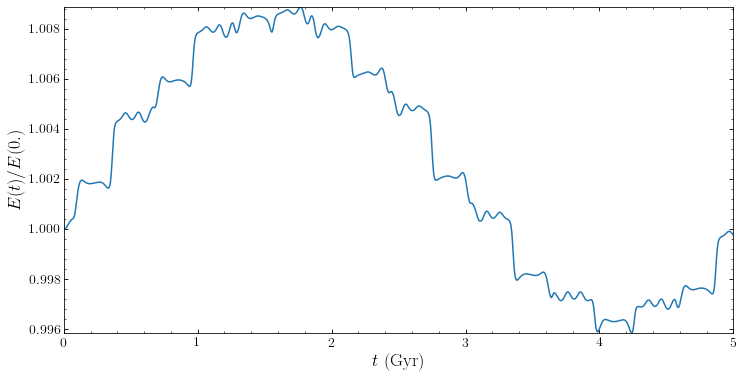

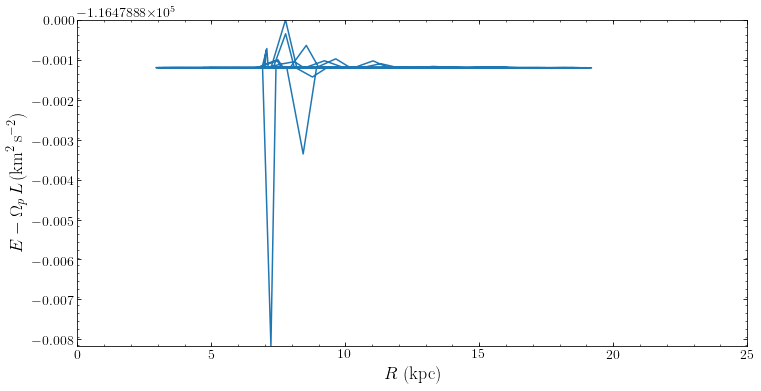

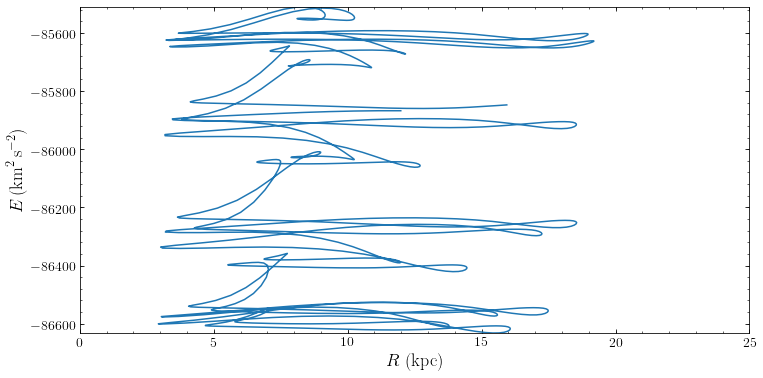

In [25]:
#leading arm

ol= Orbit([Rl[ind],vRl[ind],vTl[ind],zl[ind],vzl[ind],phil[ii]],ro=ro,vo=vo).flip()
tsl= numpy.linspace(0.,dtl[ii],1001)

ol.integrate(tsl,nobarpot) #integrate back to stripping point
oll=ol(tsl[-1]).flip()  #flip velocities for forward integration
oll.integrate(ts,barpot) 
oll.plotJacobi(normed=True)
oll.plotE(normed=True)


oll.plot(d1='R',d2='Jacobi',xrange=[0.,25])
oll.plot(d1='R',d2='E',xrange=[0.,25])
#axvline(dp._rb*ro,c='r') # this plots the bar radius

In [33]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like
orbitst= []
orbitsl= []

N=1000

finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)


for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    ot.integrate(tst,nobarpot)
    orbitst.append(ot(tst[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below
    
    #leading   
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    tsl= numpy.linspace(0.,dtl[ii],1001)
    ol.integrate(tsl,nobarpot)
    orbitsl.append(ol(tsl[-1]).flip())  # get the orbit at the final time step, flip the velocities for forward integration below
        
    
    #forward integrate in barred potential
    orbitst[ii].integrate(tst,barpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
       
    #leading
    orbitsl[ii].integrate(tsl,barpot)
    finalRl[ii]= orbitsl[ii].R(tsl[-1])
    finalphil[ii]= orbitsl[ii].phi(tsl[-1])
    finalzl[ii]= orbitsl[ii].z(tsl[-1])
    
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 

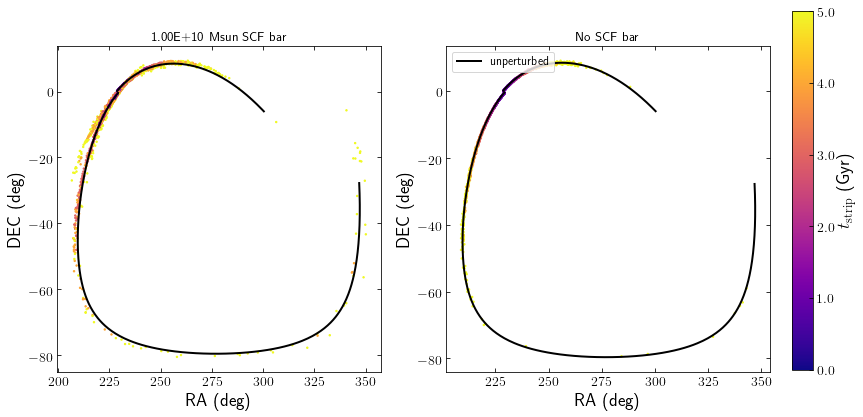

In [34]:
plt.figure(figsize=(12,6))
plt.subplot(1,2, 1)
plt.title('%.2E Msun SCF bar'%Decimal(Mbar))
plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 2, 2)
plt.title('No SCF bar')
plt.scatter(radec1t[:,0],radec1t[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

plt.scatter(radec1l[:,0],radec1l[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')

plt.savefig('plots/Pal5_Mbar10_10Msun_patspeed35_barangle27.pdf',format='pdf',dpi=1000)
plt.show()


    

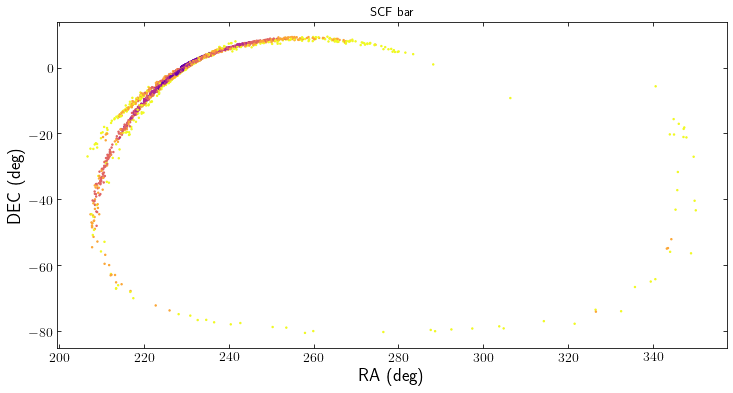

In [35]:
plt.figure(figsize=(12,6))

plt.title('SCF bar')
plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.show()

In [ ]:
#in spherical coordinates

def r1s(R,t,p):
    return R* ( np.sin(t)**4. + np.cos(t)**4.)**(0.25)

def r2s(R,t,p):
    return R*( (q*np.sin(t)/z0)**2. * ((x0*np.cos(p))**2. + (y0*np.sin(p))**2.)  + np.cos(t)**2. )**0.5


def rho_bar_sp(R,t,p):
    return np.exp(-r1s(R,t,p)**2./2.) + r2s(R,t,p)**(-1.85)*np.exp(-r2s(R,t,p))


In [ ]:
#Learn how to use triple quad

from scipy import integrate
import numpy as np

a=2.
b=3.
c=4.

#Return the triple integral of func(z, y, x) from x = a..b, y = gfun(x)..hfun(x), and z = qfun(x,y)..rfun(x,y).

def rfun(x,y):
    return c*np.sqrt(1 - (x/a)**2 - (y/b)**2)

def qfun(x,y):
    return 0.

def gfun(x):
    return 0.

def hfun(x):
    return b*np.sqrt(1-(x/a)**2.)

def ff(z,y,x):
    return 1.

print 8.*integrate.tplquad(ff,0.,2.,gfun,hfun,qfun,rfun)[0]

print 4.*np.pi*a*b*c/3.

In [ ]:
print rho0

In [ ]:
import numpy as np
from scipy import integrate

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=2*10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))

xx=np.linspace(-5.,5.,10000)
yy=np.linspace(-5.,5.,10000)
zz=np.linspace(-5.,5.,10000)




In [ ]:
from mayavi import mlab 
figure = mlab.figure('Bar density')
pts = mlab.points3d(xx, yy, zz, rho_bar, scale_mode='none', scale_factor=0.7)
mlab.axes()
mlab.show()

In [ ]:
from scipy import integrate
import numpy as np

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=2*10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))



def rfun(x,y):
    return z0*np.sqrt(1 - (x/x0)**2 - (y/y0)**2)

def qfun(x,y):
    return 0.

def hfun(x):
    return y0*np.sqrt(1-(x/x0)**2.)

def gfun(x):
    return 0.

#the density form has the symmetry under x --> -x , y --> -y, z--> -z 

norm= 8.*integrate.tplquad(rho_bar,0.,x0,gfun,hfun,qfun,rfun)[0]

print norm

rho0=Mbar/norm

In [ ]:
def ff2(R):
    

print integrate.quad(ff2,0,np.inf)[0]

In [ ]:
print 2./4*2

In [ ]:
def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar_xyz(z,y,x):
    return rho0*(np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x)))